In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
% cd drive/MyDrive/using-a2c/

/content/drive/MyDrive/using-a2c


In [3]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch

import gym

from a2c.a2c import A2C
from a2c.callback import ProgressBarCallback

from baseline_policies.threshold import Threshold

from environments.continuous_teaching import ContinuousTeaching
from environments.discontinuous_teaching import DiscontinuousTeaching

import random

from human_agents import generate_agents

In [4]:
%config InlineBackend.figure_format = "retina"
sns.set()

# Without breaks

In [5]:
n_users = 100
n_items = 30
random.seed(123)
user = random.randint(0, n_users)
forget_rates, repetition_rates = generate_agents(n_users, n_items)
print("forget", forget_rates.mean())
print("repeat", repetition_rates[user].mean())

env = ContinuousTeaching(
        t_max=100,
        initial_forget_rates=forget_rates[user],
        initial_repetition_rates=repetition_rates[user],
        n_item=n_items,
        tau=0.9)

forget 0.027489510141681783
repeat 0.16956679844402534


## Using A2C

In [6]:
model = A2C(env, seed=123)

iterations = env.t_max * 1000
check_freq = env.t_max

with ProgressBarCallback(env, check_freq) as callback:
    model.learn(iterations, callback=callback)

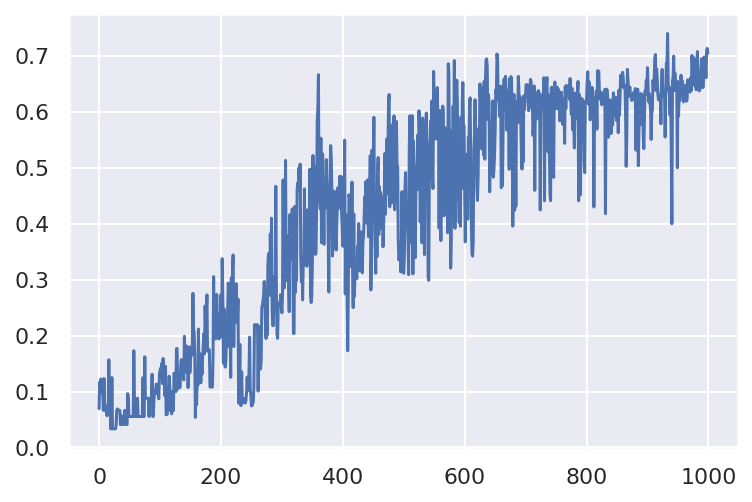

In [7]:
plt.plot([np.mean(r) for r in callback.hist_rewards])

In [8]:
def run_one_episode(env, policy):
    rewards = []
    actions = []

    obs = env.reset()
    while True:
        action = policy.act(obs)
        obs, reward, done, info = env.step(action)

        rewards.append(reward)
        actions.append(action)

        if done:
            obs = env.reset()
            break
            
    return rewards, actions

In [9]:
rewards, actions = run_one_episode(env=env, policy=model)

In [10]:
print("sum rewards:", np.sum(rewards))

sum rewards: 70.26666666666667


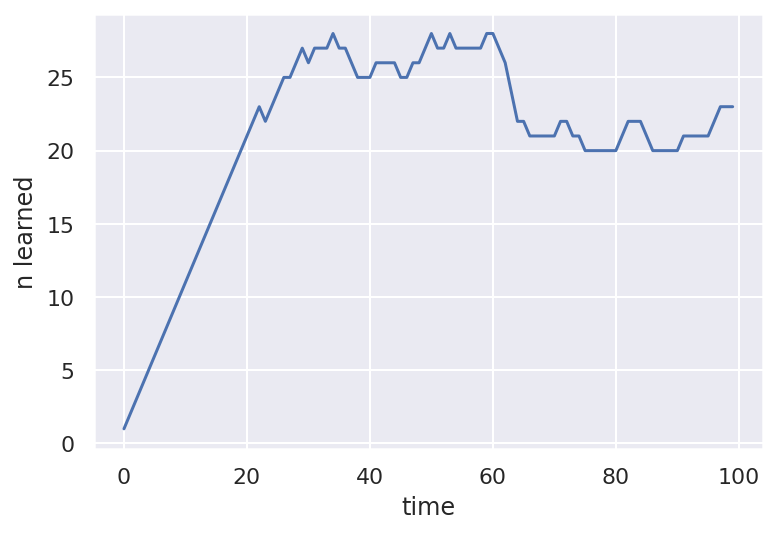

In [11]:
n_learned = np.array(rewards)*env.n_item

fig, ax = plt.subplots()
ax.plot(n_learned)
ax.set_xlabel("time")
ax.set_ylabel("n learned");

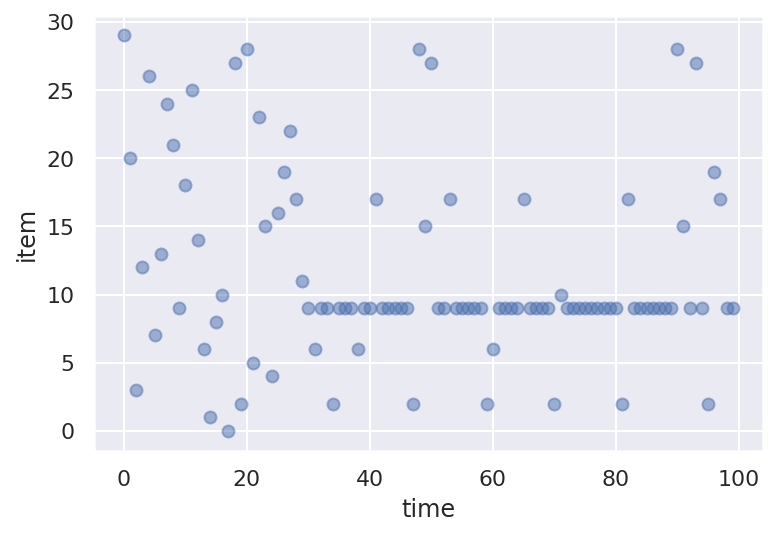

In [12]:
fig, ax = plt.subplots()
ax.scatter(np.arange(env.t_max), actions, alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("item");

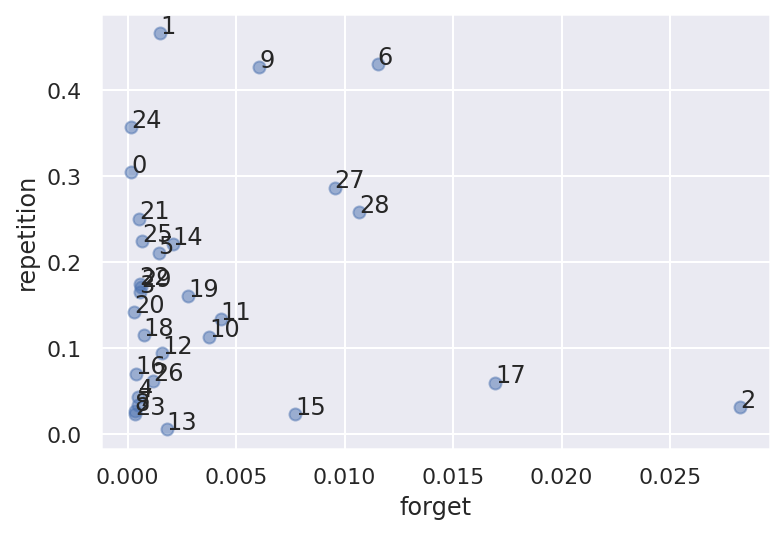

In [13]:
fig, ax = plt.subplots()
ax.scatter(forget_rates[user], repetition_rates[user], alpha=0.5)
ax.set_xlabel("forget")
ax.set_ylabel("repetition");
for i, txt in enumerate(range(n_items)):
    ax.annotate(txt, (forget_rates[user][i], repetition_rates[user][i]))

In [ ]:
# Test save and load
model.save("bkp/a2c_demo.p")
model = model.load("bkp/a2c_demo.p")

## Using Threshold (myopic)

In [14]:
obs = env.reset()
policy = Threshold(env=env, tau=0.9)
rewards = []
actions = []
while True:
    action = policy.act(obs)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

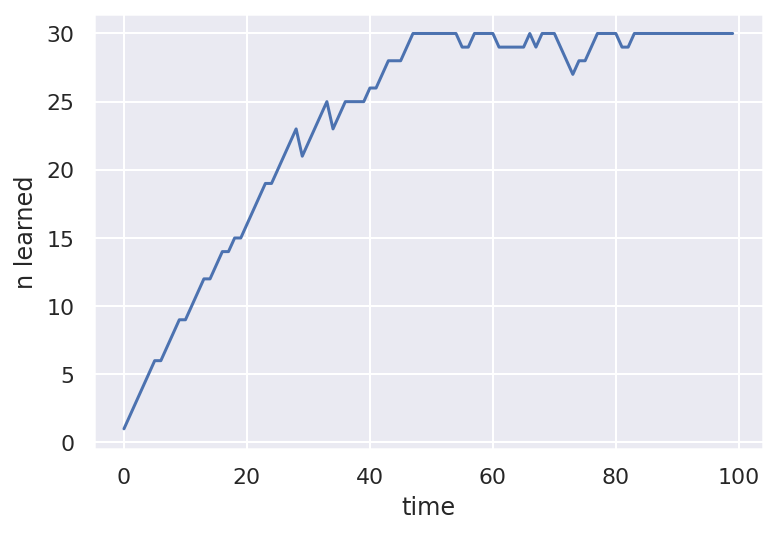

In [15]:
n_learned = np.array(rewards)*env.n_item

fig, ax = plt.subplots()
ax.plot(n_learned)
ax.set_xlabel("time")
ax.set_ylabel("n learned");

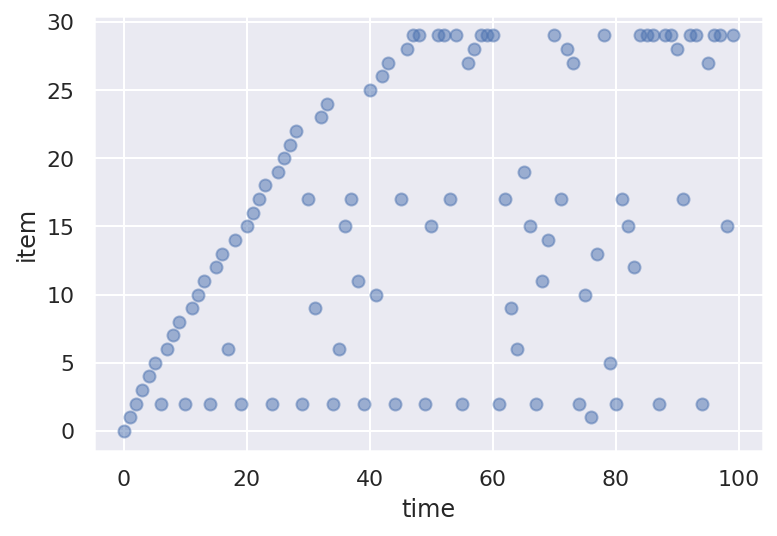

In [16]:
fig, ax = plt.subplots()
ax.scatter(np.arange(env.t_max), actions, alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("item");

# With breaks

In [17]:
env = DiscontinuousTeaching(
        tau=0.9, 
        break_length=24*60**2,
        time_per_iter=3, 
        n_iter_per_session=100,
        initial_forget_rates=forget_rates[user],
        initial_repetition_rates=repetition_rates[user],
    )

## Using Threshold (myopic)

In [18]:
obs = env.reset()
policy = Threshold(tau=0.9, env=env)
rewards = []
actions = []
while True:
    action = policy.act(obs)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

In [19]:
rewards = np.array(rewards)*env.n_item

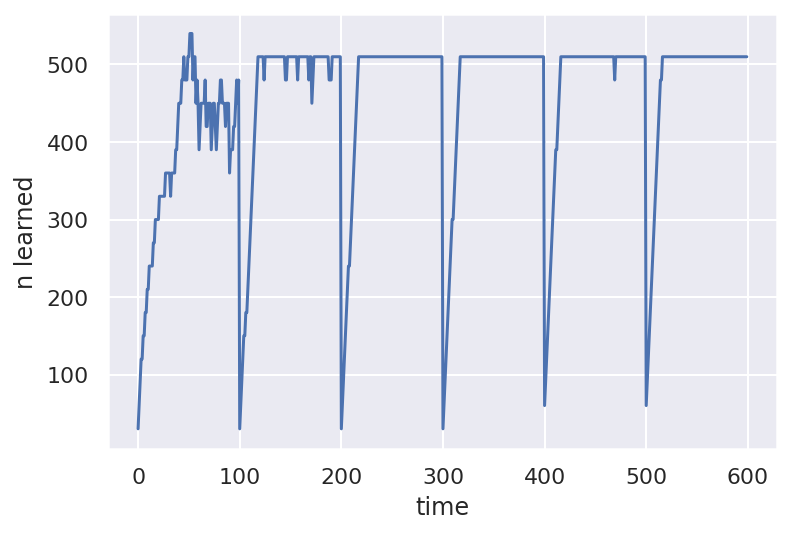

In [20]:
n_learned = np.array(rewards)*env.n_item

fig, ax = plt.subplots()
ax.plot(n_learned)
ax.set_xlabel("time")
ax.set_ylabel("n learned");

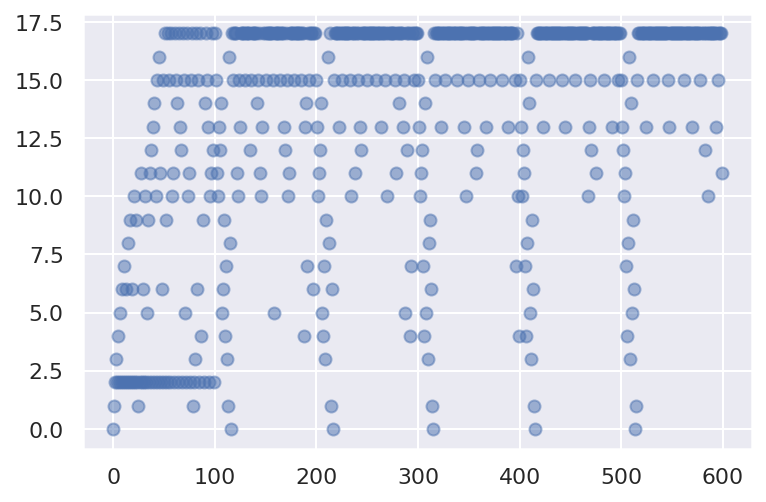

In [21]:
plt.scatter(np.arange(len(actions)), actions, alpha=0.5);

## Using A2C

In [22]:
model = A2C(env, seed=123)

env_t_max = env.n_session*env.n_iter_per_session
iterations = env_t_max * 10000
check_freq = env_t_max

with ProgressBarCallback(env, check_freq) as callback:
    model.learn(iterations, callback=callback)

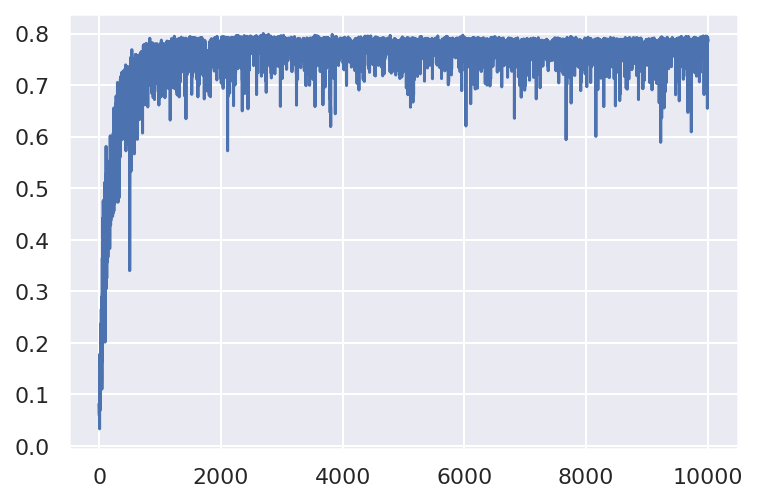

In [23]:
plt.plot([np.mean(r) for r in callback.hist_rewards])

In [24]:
rewards = []
actions = []

obs = env.reset()
while True:
    action = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    
    rewards.append(reward)
    actions.append(action)
    
    if done:
        obs = env.reset()
        break

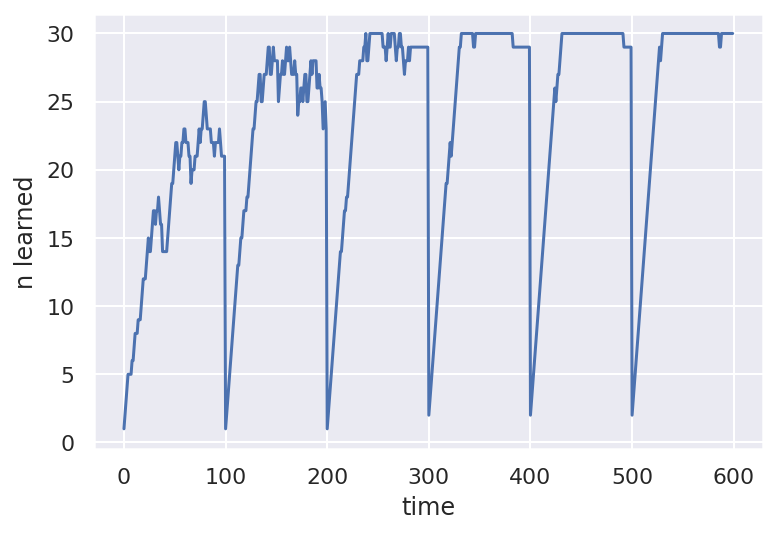

In [25]:
n_learned = np.array(rewards)*env.n_item

fig, ax = plt.subplots()
ax.plot(n_learned)
ax.set_xlabel("time")
ax.set_ylabel("n learned");

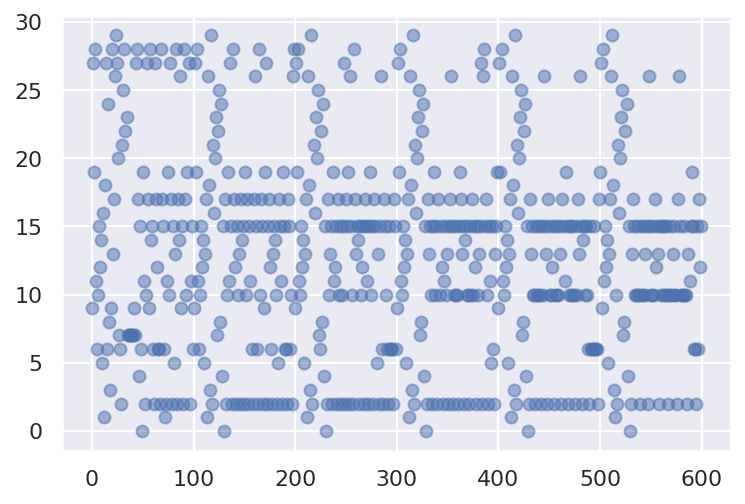

In [27]:
plt.scatter(np.arange(env_t_max), actions, alpha=0.5);